<a href="https://colab.research.google.com/github/laffertybrian/W_William_Project_001/blob/main/Genetic_Variant_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay

In [94]:
# Loading dataset

df = pd.read_csv('/content/drive/MyDrive/Data Science Projects/W_William_Project/clinvar_conflicting.csv', dtype={'CHROM': str, 38: str, 40: object})
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [96]:
def dataframe_statistics(DF):
  """Takes input of a dataframe and retuns a summary dataframe of key statistics"""

  # initialize lists for data storage
  feature_list = []
  dtype_list = []
  values_list = []
  missing_values_list = []
  data_percent_list = []
  unique_values_list = []
  number_unique_values_list = []

  for column in DF.columns:

    # length and missing values of column
    entries = len(DF[column])
    missing = DF[column].isna().sum()

    feature_list.append(column)
    dtype_list.append(DF[column].dtype)
    values_list.append(entries - missing)
    missing_values_list.append(missing)
    data_percent_list.append(round((entries - missing) / entries, 2))
    unique_values_list.append(DF[column].unique())
    number_unique_values_list.append(len(DF[column].value_counts()))

  # creating summary dataframe for return
  summary = pd.DataFrame({'Features': feature_list, 'Dtype': dtype_list, 
                          '#_Values': values_list, '#_Missing_Values': missing_values_list, 
                          '%_Data': data_percent_list, 'Unique_Values': unique_values_list,
                          '#_Unique_Values': number_unique_values_list})
  
  summary = summary.set_index('Features')
  

  return summary.sort_values(by = '#_Missing_Values', ascending = False)

In [97]:
df_summary = dataframe_statistics(df)
df_summary

,Dtype,#_Values,#_Missing_Values,%_Data,Unique_Values,#_Unique_Values
Features,,,,,,
MOTIF_SCORE_CHANGE,float64,2,65186,0.00,"[nan, -0.063, -0.097]",2
HIGH_INF_POS,object,2,65186,0.00,"[nan, N]",1
MOTIF_POS,float64,2,65186,0.00,"[nan, 1.0]",1
MOTIF_NAME,object,2,65186,0.00,"[nan, Egr1:MA0341.1, FOXA1:MA0546.1]",2
DISTANCE,float64,108,65080,0.00,"[nan, 1811.0, 1855.0, 2202.0, 1651.0, 1407.0, ...",96
SSR,float64,130,65058,0.00,"[nan, 1.0, 16.0]",2
CLNSIGINCL,object,167,65021,0.00,"[nan, 424754:Likely_pathogenic, 30118:risk_fac...",137
CLNDISDBINCL,object,167,65021,0.00,"[nan, MedGen:C1828210,OMIM:153870,Orphanet:ORP...",93
CLNDNINCL,object,167,65021,0.00,"[nan, Bull's_eye_maculopathy|Methylmalonic_aci...",101


In [98]:
df.drop(df[df['Codons'].isna()].index, inplace=True)
df.drop(df[df['CADD_RAW'].isna()].index, inplace=True)
df.drop(df[df['MC'].isna()].index, inplace=True)
df.drop(df[df['LoFtool'].isna()].index, inplace=True)
df.drop(df[df['EXON'].isna()].index, inplace=True)

In [99]:
df_summary_1 = dataframe_statistics(df)
df_summary_1

,Dtype,#_Values,#_Missing_Values,%_Data,Unique_Values,#_Unique_Values
Features,,,,,,
INTRON,object,0,50248,0.00,[nan],0
MOTIF_NAME,object,0,50248,0.00,[nan],0
DISTANCE,float64,0,50248,0.00,[nan],0
MOTIF_SCORE_CHANGE,float64,0,50248,0.00,[nan],0
HIGH_INF_POS,object,0,50248,0.00,[nan],0
MOTIF_POS,float64,0,50248,0.00,[nan],0
SSR,float64,95,50153,0.00,"[nan, 1.0, 16.0]",2
CLNDNINCL,object,143,50105,0.00,"[nan, Bull's_eye_maculopathy|Methylmalonic_aci...",86
CLNSIGINCL,object,143,50105,0.00,"[nan, 424754:Likely_pathogenic, 30118:risk_fac...",117


In [100]:
# columns with data less than 100%
columns_to_drop = list(df_summary_1[df_summary_1["#_Missing_Values"] > 1].index)

df.drop(columns = columns_to_drop, inplace = True)

summary = dataframe_statistics(df)
summary

,Dtype,#_Values,#_Missing_Values,%_Data,Unique_Values,#_Unique_Values
Features,,,,,,
CHROM,object,50248,0,1.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",23
IMPACT,object,50248,0,1.0,"[MODERATE, LOW, HIGH]",3
CADD_PHRED,float64,50248,0,1.0,"[0.172, 23.0, 11.36, 22.1, 26.1, 6.773, 22.2, ...",7699
LoFtool,float64,50248,0,1.0,"[0.101, 0.021, 0.0674, 0.183, 0.3, 0.372, 0.27...",1181
STRAND,float64,50248,0,1.0,"[1.0, -1.0]",2
Codons,object,50248,0,1.0,"[Tcg/Ccg, cCt/cTt, Gtg/Atg, aCg/aTg, Cgg/Tgg, ...",1285
Amino_acids,object,50248,0,1.0,"[S/P, P/L, V/M, T/M, R/W, A/V, R/H, R/Q, V/I, ...",581
Protein_position,object,50248,0,1.0,"[534, 634, 1102, 1225, 1192, 1110, 961, 959, 8...",6608
CDS_position,object,50248,0,1.0,"[1600, 1901, 3304, 3674, 3574, 3329, 2882, 287...",12261


###Prepare data for modling

In [101]:
# dropping all object columns for simple model creation
cat_cols = df.select_dtypes('object').columns
df.drop(columns = cat_cols, inplace = True)

In [102]:
# creating feature matrix and target vector
X = df.drop(columns = 'CLASS')

y = df['CLASS']

In [103]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [104]:
# creating column selectors
numerical_cols = make_column_selector(dtype_include='number')

category_cols = make_column_selector(dtype_include='object')

# instantiate scaler and onehotencoder
scaler = StandardScaler()

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse = False)

# creating pipelines
numeric_tuple = (scaler, numerical_cols)
category_tuple = (one_hot_encoder, category_cols)

# column transformer
#preprocessor = make_column_transformer(numeric_tuple, category_tuple, remainder='passthrough')
preprocessor = make_column_transformer(numeric_tuple, remainder='passthrough')

In [105]:
# transform train and test dataset
#preprocessor.fit(X_train)
#X_train_processed = preprocessor.transform(X_train)
#X_test_processed = preprocessor.transform(X_test)

###Model Construction




####Logistic Regression

In [106]:
# creating an instance of logistic regression
logistic_regression = LogisticRegression(max_iter = 1000, random_state=42)
# creating a pipeline for the preprossor and the model
logistic_regression_pipe = make_pipeline(preprocessor, logistic_regression)
# fitting the log reg pipe on the training data
logistic_regression_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f34d46bb5d0>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [107]:
# using the logistics regression model to predict for train and test data
logistic_regression_train_predictions = logistic_regression_pipe.predict(X_train)
logistic_regression_test_predictions = logistic_regression_pipe.predict(X_test)

In [108]:
# reviewing the training and test score of the model (accuracy score)
print('Training Score of Logistic Regression model', + logistic_regression_pipe.score(X_train, y_train))
print('Test Score of Logistics Regression model', + logistic_regression_pipe.score(X_test, y_test))

Training Score of Logistic Regression model 0.7501459427904261
Test Score of Logistics Regression model 0.7538608501830919


In [115]:
# Additional metrics for the test set on the performance of the model
print(f'Logistic Regression Accuracy {accuracy_score(y_test, logistic_regression_test_predictions)}')
print(f'Logistic Regression Recall Score {recall_score(y_test, logistic_regression_test_predictions)}')
print(f'Logistic Regression Precision Score {precision_score(y_test, logistic_regression_test_predictions)}')

Logistic Regression Accuracy 0.7538608501830919
Logistic Regression Recall Score 0.0
Logistic Regression Precision Score 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


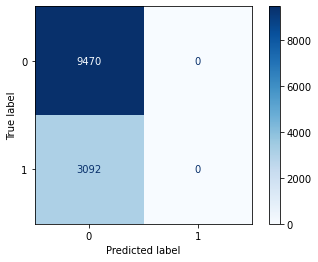

In [114]:
# viewing the confusion matrix
#labels = ['drugQ', 'drugZ']   then in the matrix would put display_labels = labels
ConfusionMatrixDisplay.from_predictions(y_test, logistic_regression_test_predictions, cmap='Blues');

####Random Forest

In [116]:
# Instantiate random forest model
random_forest = RandomForestClassifier(random_state=42)
# creating pipeline for data and model
random_forest_pipe = make_pipeline(preprocessor, random_forest)
# fit the model with the training data
random_forest_pipe.fit(X_train, y_train)
# predict with the random forest model
random_forest_test_predictions = random_forest_pipe.predict(X_test)
random_forest_train_predictions = random_forest_pipe.predict(X_train)

In [117]:
# reviewing the training and test score of the model (accuracy score)
print('Training Score of Random Forest model', + random_forest_pipe.score(X_train, y_train))
print('Test Score of Random Forest model', + random_forest_pipe.score(X_test, y_test))

Training Score of Random Forest model 0.9999734649471952
Test Score of Random Forest model 0.7593536061136762


In [118]:
# reviewing the metrics of the best random forest model on the test data
print(f'Best Random Forest Accuracy {accuracy_score(y_test, random_forest_test_predictions)}')
print(f'Bset Random Forest Recall Score {recall_score(y_test, random_forest_test_predictions)}')
print(f'Best Random Forest Precision Score {precision_score(y_test, random_forest_test_predictions)}')

Best Random Forest Accuracy 0.7593536061136762
Bset Random Forest Recall Score 0.31241914618369987
Best Random Forest Precision Score 0.5185185185185185


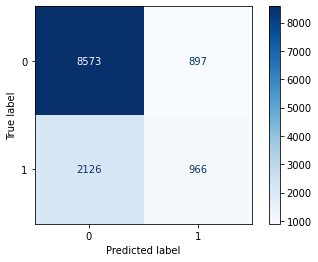

In [119]:
# creating a confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, random_forest_test_predictions, cmap='Blues');

###KNN

In [120]:
# Instantiating the knn model
knn = KNeighborsClassifier()
# creating a pipe and adding a scaler
knn_pipe = make_pipeline(preprocessor, knn)
# fitting the pipeline on the training data
knn_pipe.fit(X_train, y_train)
# predictions with knn model
knn_test_predictions = knn_pipe.predict(X_test)
knn_train_predictions = knn_pipe.predict(X_train)

In [121]:
# reviewing the training and test score of the model (accuracy score)
print('Training Score of KNN model', + knn_pipe.score(X_train, y_train))
print('Test Score of KNN model', + knn_pipe.score(X_test, y_test))

Training Score of KNN model 0.8028710927134745
Test Score of KNN model 0.717003661837287


In [122]:
# reviewing the detailed metrics from the knn model on test data
print(f'KNN Accuracy {accuracy_score(y_test, knn_test_predictions)}')
print(f'KNN Recall Score {recall_score(y_test, knn_test_predictions)}')
print(f'KNN Precision Score {precision_score(y_test, knn_test_predictions)}')

KNN Accuracy 0.717003661837287
KNN Recall Score 0.2296248382923674
KNN Precision Score 0.3770578863515667


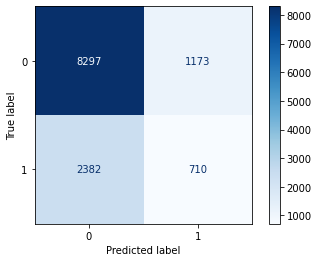

In [123]:
# reviewing the confusion matrix for the best KNN model on the test data
ConfusionMatrixDisplay.from_predictions(y_test, knn_test_predictions, cmap='Blues');

###Neural Network

In [124]:
# prepare dataset
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# storing the dimension of X train
X_train_shape = X_train_processed.shape[1]

In [125]:
# Function to help plot history of deep learning models

def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [126]:
# instantiate the base sequential model
base_model = Sequential()
# creating the first layer of the model
base_model.add(Dense(15, input_dim = X_train_shape, activation = 'relu'))
# because this is a binary classification problem the last step will have one node and be a sigmoid activiation function
base_model.add(Dense(1, activation='sigmoid'))

In [127]:
# compile the model
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [128]:
# fittting the model
history = base_model.fit(X_train_processed, y_train,
                        validation_data = (X_test_processed, y_test),
                        epochs = 200, verbose = 0)

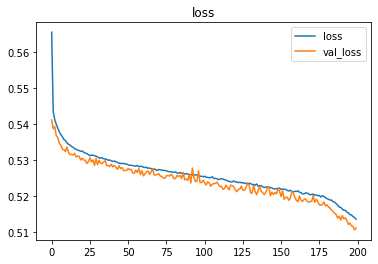

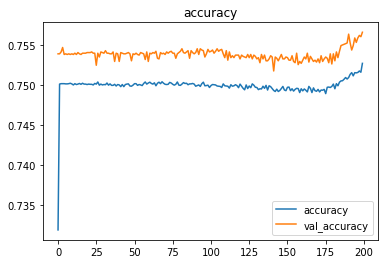

In [129]:
# plotting the history using the function above
plot_history(history)

393/393 [==============================] - 1s 2ms/step
Training Classification Report and Confusion Matrix
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     28272
           1       0.25      1.00      0.40      9414

    accuracy                           0.25     37686
   macro avg       0.12      0.50      0.20     37686
weighted avg       0.06      0.25      0.10     37686

Neural Network Accuracy 0.24980098710396434


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


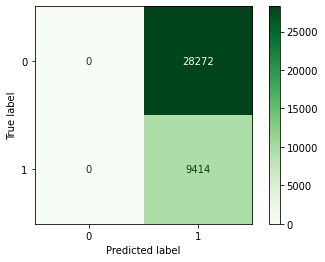

In [132]:
# creating training and testing predictions. making sure to round them
nn_train_predictions = np.rint(base_model.predict(X_train))
nn_test_predictions = np.rint(base_model.predict(X_test))

# training classification report
print('Training Classification Report and Confusion Matrix')
print(classification_report(y_train, nn_train_predictions))
print(f'Neural Network Accuracy {accuracy_score(y_train, nn_train_predictions)}')

# creating the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train, nn_train_predictions, cmap='Greens');

Testing Classification Report and Confusion Matrix
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9470
           1       0.25      1.00      0.40      3092

    accuracy                           0.25     12562
   macro avg       0.12      0.50      0.20     12562
weighted avg       0.06      0.25      0.10     12562

Neural Network Accuracy 0.24613914981690813


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


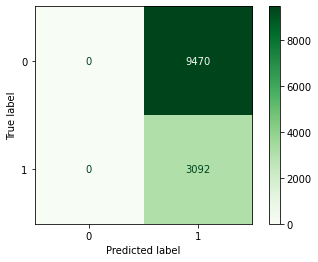

In [133]:
# testing classification report
print('Testing Classification Report and Confusion Matrix')
print(classification_report(y_test, nn_test_predictions))
print(f'Neural Network Accuracy {accuracy_score(y_test, nn_test_predictions)}')

# confusion matrix for the testing set
ConfusionMatrixDisplay.from_predictions(y_test, nn_test_predictions, cmap='Greens');